In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/airbus-ship-detection/"))

['test_v2', 'sample_submission_v2.csv', 'train_ship_segmentations_v2.csv', 'train_v2']


# Load data

In [2]:
TRAIN = os.listdir("../input/airbus-ship-detection/train_v2")
TEST = os.listdir("../input/airbus-ship-detection/test_v2")

TRAIN_DIR = '../input/airbus-ship-detection/train_v2'

In [3]:
df = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
df.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

**ImageId** - image name

**EncodedPixels** -  pixels where is ship

# Exploration

In [4]:
df.shape

(231723, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [6]:
df['Exist_ship'] = df['EncodedPixels'].apply(lambda count: 0 if pd.isna(count) else 1)
df

ImageId                                      EncodedPixels  \
0       00003e153.jpg                                                NaN   
1       0001124c7.jpg                                                NaN   
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   
...               ...                                                ...   
231718  fffedbb6b.jpg                                                NaN   
231719  ffff2aa57.jpg                                                NaN   
231720  ffff6e525.jpg                                                NaN   
231721  ffffc50b4.jpg                                                NaN   
231722  ffffe97f3.jpg                                                NaN   

        Exist_ship  
0                0  
1                0  
2                1  
3                1  
4                1  
...            ...  
231718           0  
231719           0  
231720           0  
231721           0  
231722           0  

[231723 rows x 3 columns]

In [7]:
# count pic. where is a ship
df['Exist_ship'].replace({0:False, 1:True}).sum()

81723

In [8]:
# empty pic
231723 - 81723

150000

<AxesSubplot:ylabel='Exist_ship'>

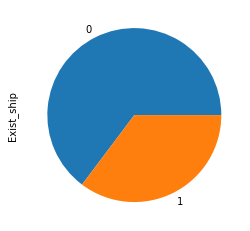

In [9]:
df['Exist_ship'].value_counts().plot(kind='pie')

## Disbalance classes with ship and no ship image (and pixels disbalance)!

In [10]:
# make copy, becouse I carry out manipulations with dataset
df2 = df.copy()
counts_df = df2.groupby(['ImageId']).agg({'Exist_ship': 'sum'}).reset_index()
counts_df.head()

ImageId  Exist_ship
0  00003e153.jpg           0
1  0001124c7.jpg           0
2  000155de5.jpg           1
3  000194a2d.jpg           5
4  0001b1832.jpg           0

In [11]:
# how many ships on images
counts_df['Exist_ship'].value_counts()

0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: Exist_ship, dtype: int64

In [12]:
# sum of all images
counts_df['Exist_ship'].value_counts().sum()

192556

<AxesSubplot:>

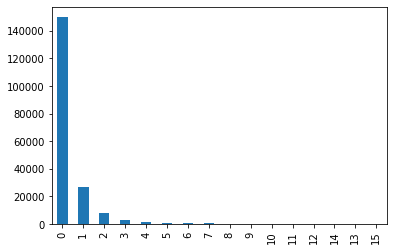

In [13]:
# how many ships on pics
counts_df['Exist_ship'].value_counts().plot(kind='bar')

42556 ships but pictures with ships is 81723. It's means that data has dublicats.

let's count them!

In [14]:
# dublicats image
81723-42556

39167

# Viewing images

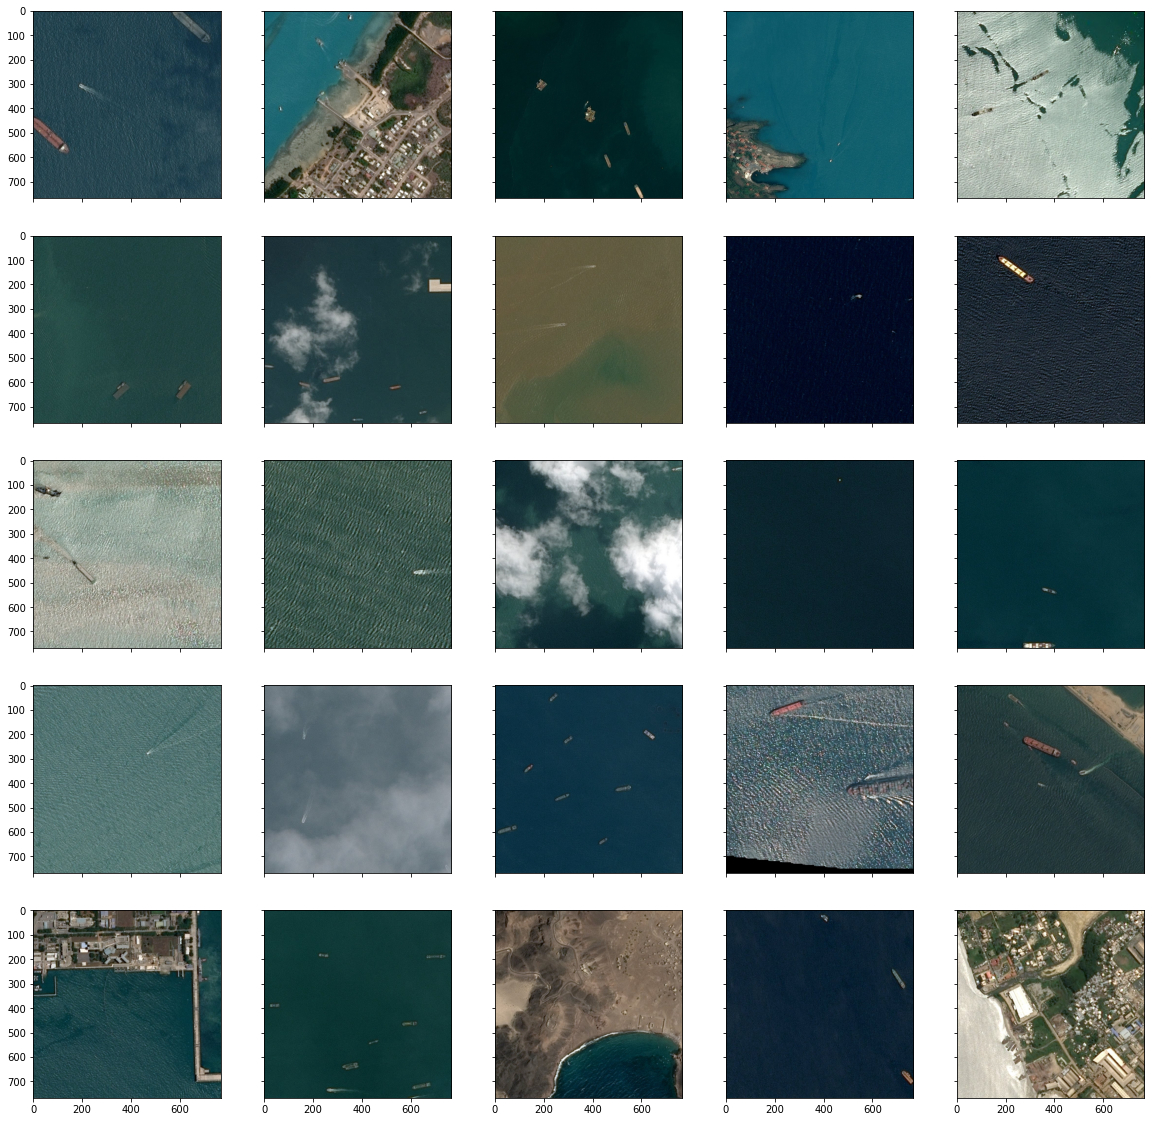

In [15]:
# ships pictures
sample = df[~df.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path('../input/airbus-ship-detection/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

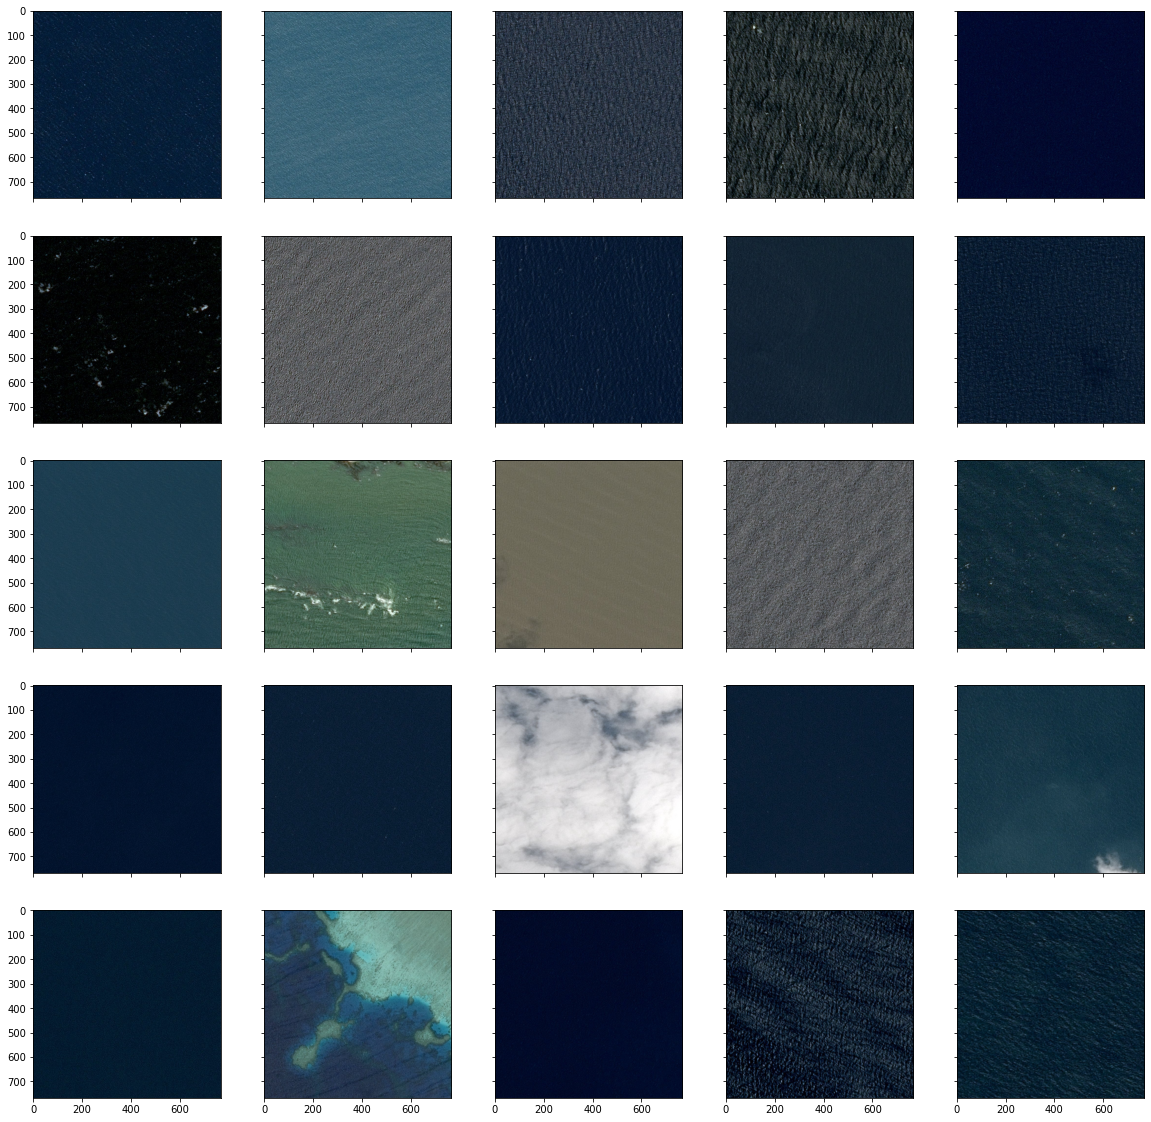

In [16]:
# pictures without ships
sample = df[df.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path('../input/airbus-ship-detection/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

In [17]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_color(in_mask_list):
    '''
    drow in color different ships
    '''
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
(768, 768)


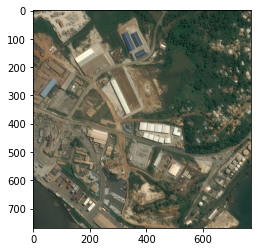

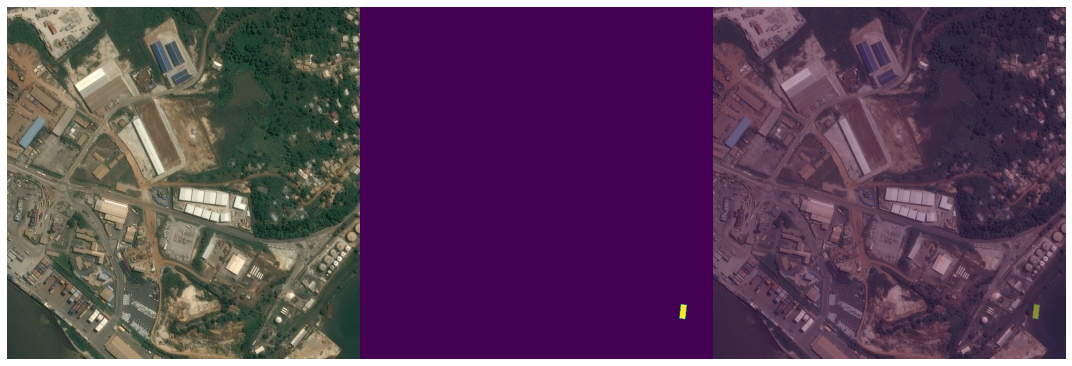

In [18]:
# try/except give for my code more optimization
# without this structure, plot showing only for image with ship
while True:
    try:
        IMG = TRAIN[np.random.randint(1000)]
        img = Image.open(TRAIN_DIR+"/"+IMG)

        plt.imshow(img)
        
        # img = imread(TRAIN+'/' + IMG)
        img_masks = df.loc[df['ImageId'] == IMG, 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        for mask in img_masks:
            all_masks += rle_decode(mask)
            
        print(img.size)

        fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[2].axis('off')
        axarr[0].imshow(img)
        axarr[1].imshow(all_masks)
        axarr[2].imshow(img)
        axarr[2].imshow(all_masks, alpha=0.4)
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()
        break
    except AttributeError as error:
        print('-')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


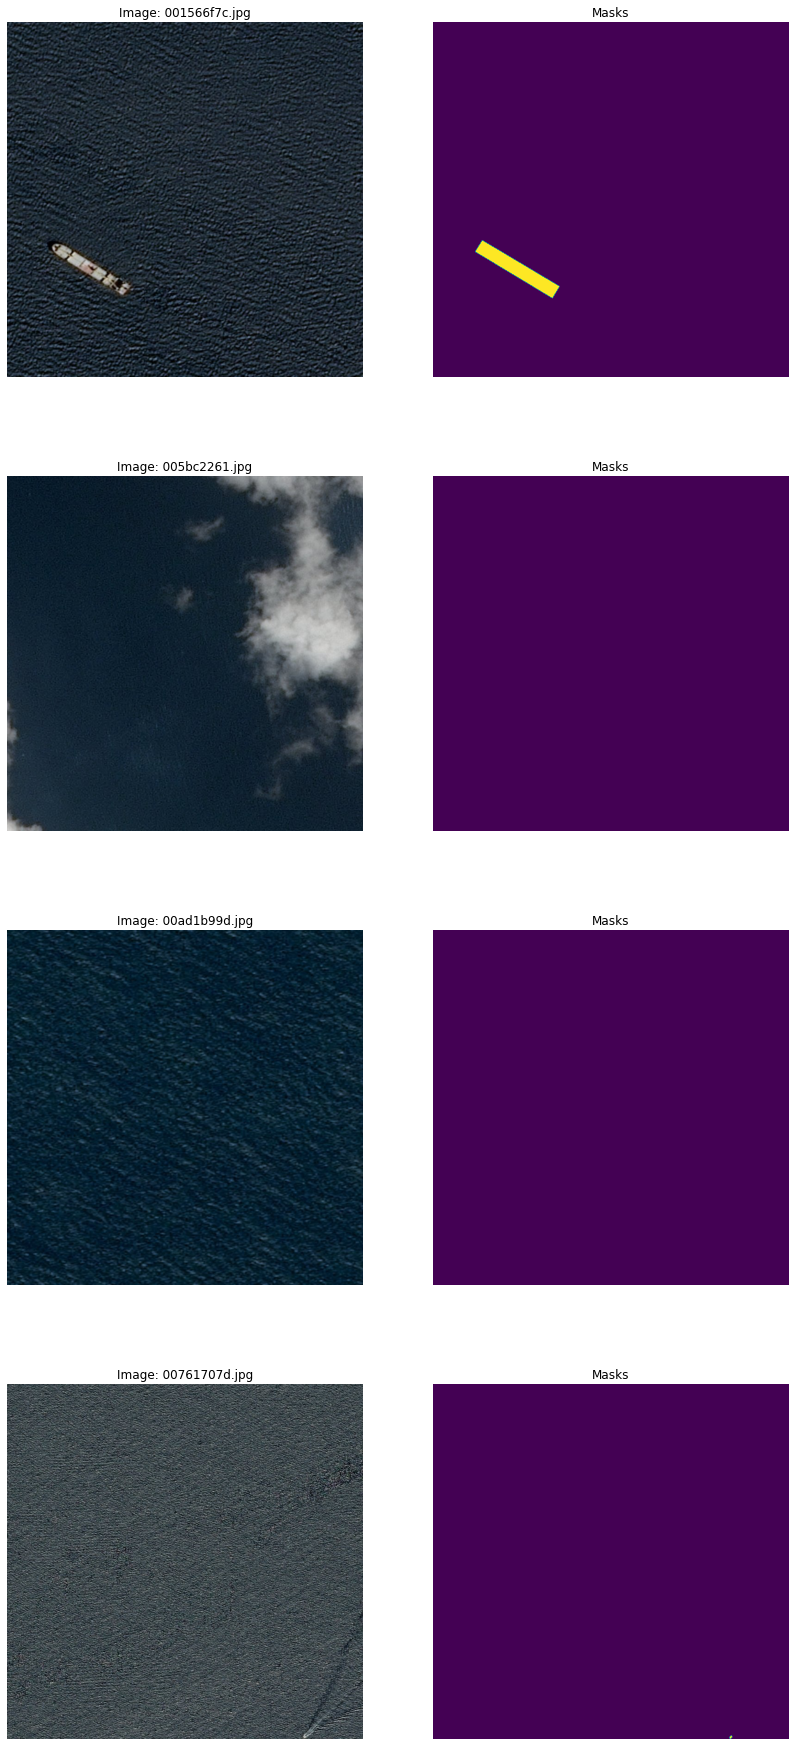

In [19]:
# compare pairs of images (original/mask) 
val = [np.random.randint(1000) for i in range(4)]

TOP_PREDICTIONS = 4
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (14, TOP_PREDICTIONS*8))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

def raw_prediction(img, path=TRAIN_DIR):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    return c_img[0]

for (ax1, ax2), c_img_name in zip(m_axs, df.ImageId.loc[val]):
    c_img = raw_prediction(c_img_name)
    ax1.imshow(c_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(df.query('ImageId==\"{}\"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Masks')